####  Urban-rural continuoun

The algorithm hs for values:

- path_tif: is the raster that will be use to create the urban-rural continuoun
- path_ccpp: is the ccpp's shape that include population data for each ccpp
- density_val_3: is the value of density that will be used tu create the urban-rural continuoun
- pob_min: is the minimun value of population accepted for creating the urban-rural continoun

In [11]:
import pandas as pd
import geopandas as gpd

import numpy as np
import rasterio as rio 

from rasterio import features                           ## The features's function allows us to extract polygon from the raster's data. This function retrive
                                                        ## a pair of data (polygon, value) for each feature found in the image.
from shapely.geometry import Polygon                    ## To create polygons from a group of coordinates
from pyproj import CRS                                  ## To define an especific CRS for a given GeoDataFrame (geopandas)

import matplotlib.pyplot as plt
%matplotlib inline

########################################################


### WE'VE STARTED DEFINING A PAIR OF FUNCTION FOR OPENING THE RASTER AND THE SHP OF CCPP
def open_raster_rio(path_r):
    with rio.open(path_r) as val_density:
        band_1=val_density.read(1, masked=True)          ## The function read(), reads the raster's values in the first band (1), without reading the negative values (masked=True)
        band_1_aff=val_density.transform                 ## The raster's affine values will be required later for georeferencing the shapes correctly.
        return band_1, band_1_aff

def open_shp(path_shp):                                  ## QUESTION! is necessary to specify the minimun dataset columns (id|idccpp_17|pob_tot17|geometry)??
    ccpp_x=gpd.read_file(path_shp)                       ## QUESTION! is efficient opening the ccpp shp each time we call function? Or can we suggest opening the data before run the final function?
    return ccpp_x
    
### BEFORE APPLYING THE FEATURES()'S FUNCTION WE'VE TO RECODE THE RASTER'S VALUES STORED IN THE FIRST BAND AS BOOLEAN. BY DOING THIS, THE FUNCTION WILL RETRIVE ONLY THE DATA OF INTEREST
def recode_raster(density_val, band):                    ## QUESTION! I believe this function needs 3 args: min_value, max_value and the specified band
    band[band < density_val] = 0
    band[band >= density_val] = 1
    return band

### SINCE THE FEATURES()'S FUNCTION RETRIEVES A PAIR OF DATA (GEOMETRY AND VALUE), IS NECESSARY TO DEFINE A FUNCTION FOR EXTRACTING AND CONVERTING THE RETRIVED GEOMETRY TO POLYGON.
### TO DO THIS WE GOING TO USE SHAPELY'S FUNCTION NAMED POLYGON
def extract_coord(coor):
    coor_tuple=coor.get('coordinates')  ## Using the dictionary key named "coordinates", we call the coordinate's tuples
    poly=Polygon(coor_tuple[0])         ## Create a Polygon using the geometries from the areas extracted from the raster
    return poly

### THE FUNCTION "EXTRACT_SHAPES" RETRIEVE THE POLYGONS FROM THE DENSITY'S RASTER ACCORDING TO AN ESPECIFIED DENSITY VALUE.
def extract_shapes(density_val_2, band_ex_2, band_1_aff_2):
    data={'raw_geometry':[]}
    
    band_ex_2=recode_raster(density_val_2, band_ex_2)                             ## Call recode_raster() function to recode the raster's values according with the density's value needed 
    mask_shp = band_ex_2 == 1                                                     ## masking the raster value according to the boolean values defined in the recode_raster() function: keep only raster's values == 1
    for geom, value in features.shapes(band_ex_2,                                 ## for geom and value in band_ex_2(the raster's band called) apply the rasterios' function features.shapes()
                                       mask=mask_shp, transform=band_1_aff_2,     ## use the mask = mask_shp to retrieve only the boolean value ==1 and the transform = band_1_aff_2 for keeping the original raster's coordinates
                                       connectivity=8):                           ## use 8 pixel connectivity for grouping pixels into features (accepted values are 4 and 8)
        data['raw_geometry'].append(extract_coord(geom))
    
    den_1=gpd.GeoDataFrame(data, geometry='raw_geometry')                         ## using data dict create a GeoDataFrame where geometry is iqual to the extracted geometries that had got before
    den_1.crs = CRS.from_epsg(32718)                                              ## define the CRS for the new GeoDataFrame
    return den_1

### SINCE THE CONTINUUM ARE DEFINED AS POLYGONES WITH WITH A MINIMUN NUMBER OF PEOPLE, WE NEED TO PASS THE POPULATION'S DATA IN ORDER TO ONLY KEEP THE POLYGON THAT MATCH THE GIVEN CRITERIA.
def population_criteria(density_shp,ccpp_x, pob_min_0):
    pob_d1=density_shp.sjoin(ccpp_x, how='right',predicate='intersects')          ## using the density polygon GeoDataframe and the ccpp's shape, we do a spatial join using intersects (IS IT CORRECT?)

    pob_d1=pob_d1.dropna(subset=['index_left']).groupby('index_left').sum()       ## summing the population inside the same polygon
    pob_d1=pob_d1[pob_d1.pob_tot17>=pob_min_0].copy()                             ## retriving the polygon that match with the given condition

    den_1f=density_shp.merge(pob_d1, left_index=True, right_index=True,           ## merge the dataset
                             how='inner')                                         ## merge only the polygon which are in both GeodataFrame: all polygon and the polygons that match minimum population condition
    return den_1f

### AT LAST, WE CALL THE FUNCTION DEFINED ABOVE TO CREATE A NEW FUNCTION NAMED CONTINUUM WHICH RETRIEVE POLYGONS ACCORDING THE DENSITY VALUE AND THE MINIMUN POPULATION ACCEPTED
def continuum(density_tif, ccpp_shp ,density_val_3, pob_min):
    band_1, dem_af1=open_raster_rio(density_tif)                                  ## retriving the band and the affine from the raster
    den_1=extract_shapes(density_val_3, band_1, dem_af1)                          ## extracting shapes from the raster band using an specific affine and according to the specified density value
    
    ccpp_x=open_shp(ccpp_shp)                                                     ## opening the ccpp's shape
    
    shp_density= population_criteria(den_1,ccpp_x, pob_min)                       ## mathing the density polygon with the population criteria
    return shp_density

In [12]:
## Define the general path
path_d=r"C:\Users\Guillermo\Desktop/Python\01. Continuo urbano-rural\01. Dataset"

## define data of Cajamarca's ccpp
ccpp_06=(path_d+"\\caja_ccpp_edit.shp")
### we define the right path
path_density=(path_d+"\\costal_north_region_clip.tif")

## Open the GEOtif file using rasterio
high=continuum(path_density,ccpp_06 ,3.9, 50000)
medium=continuum(path_density,ccpp_06,0.8, 5000)
low=continuum(path_density,ccpp_06 ,0.13, 1)


<AxesSubplot:>

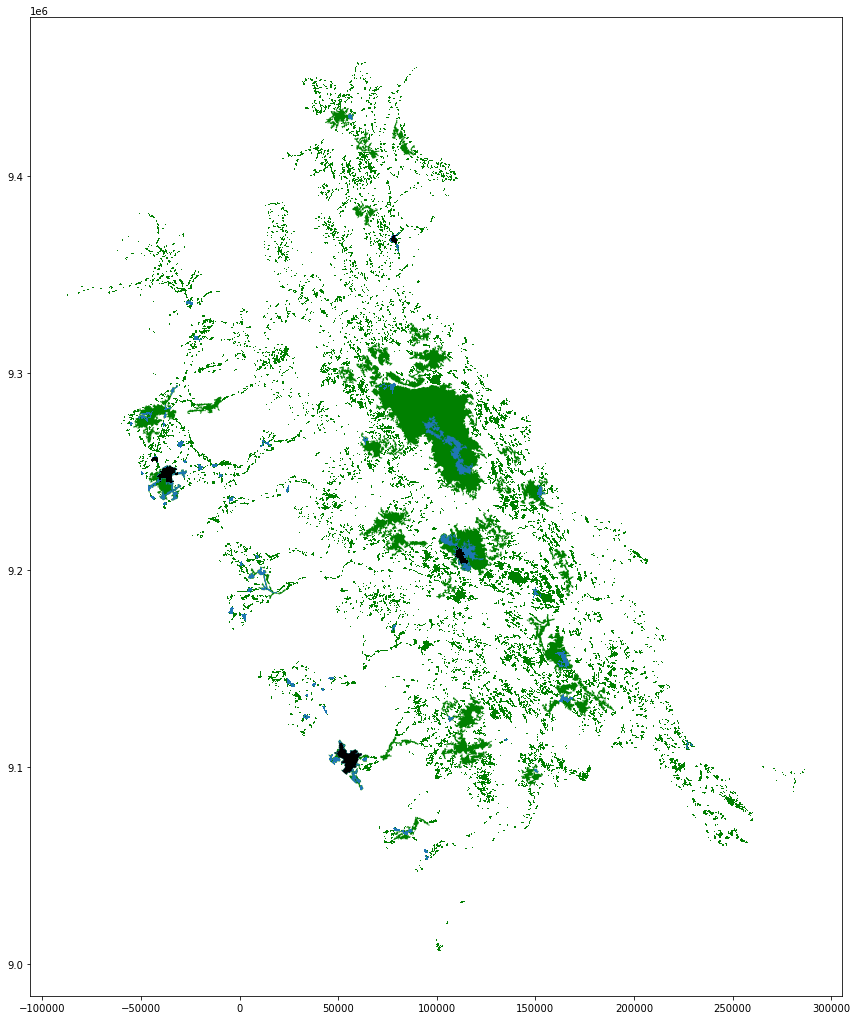

In [14]:
fig, ax=plt.subplots(figsize=(18,18))

low.plot(ax=ax, facecolor='green')
medium.plot(ax=ax)
high.plot(ax=ax,facecolor='black')

In [ ]:
# import pprint
# pprint.pprint(next(shapes))

In [ ]:


https://gis.stackexchange.com/questions/92176/gdal-polygonize-in-python-creating-blank-polygon


https://hatarilabs.com/ih-en/how-to-convert-a-raster-to-contours-with-python-and-gdal-tutorial

https://gis.stackexchange.com/questions/268331/how-can-i-extract-contours-from-a-raster-with-python